In [1]:
import os
from pathlib import Path
from dotenv import load_dotenv

load_dotenv()
os.chdir(os.getenv("PROJECT_ROOT"))

In [2]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, normalized_mutual_info_score, adjusted_rand_score
import numpy as np
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment


In [1]:
from patrec.utils.loaders import StratifiedTSLoader
from patrec.utils.visuals import plot_series as custom_plot_series
from patrec.utils.files_helper import JSON_Handler, YAML_Config
from patrec.clustering.base import visualize_cluster_errors, visualize_cluster_composition


import mlflow 
from patrec.utils.mlflow_exp import MLflow_Experiment_Logger

ModuleNotFoundError: No module named 'patrec'

In [4]:
def _map_clusters(y_true: np.ndarray, y_pred: np.ndarray, filter_by: str = 'true') -> tuple:
        """
        Maps predicted cluster labels to true class labels using the Hungarian algorithm
        to minimize misclassification cost. This allows comparison of clustering results
        against ground truth.

        Args:
            y_true: Array of true class labels (n_samples,).
            y_pred: Array of predicted cluster labels (n_samples,).
            filter_by: Controls which set of unique labels to use as reference ('true' or 'pred').

        Returns:
            tuple: (mapped_labels, mapping_dict, confusion_matrix)
                - mapped_labels: Predicted labels after optimal reassignment.
                - mapping_dict: Dictionary mapping {true_class: assigned_cluster} after optimization.
                - confusion_matrix: Confusion matrix between true and mapped predicted labels.
        """
        unique_true = np.unique(y_true)
        unique_pred = np.unique(y_pred)

        # Construct confusion matrix based on larger set to avoid missing classes
        if len(unique_pred) > len(unique_true):
            conf_matrix = confusion_matrix(y_true, y_pred, labels=unique_pred)
        else:
            conf_matrix = confusion_matrix(y_true, y_pred, labels=unique_true)

        # Use negative cost matrix for maximization (Hungarian algorithm minimizes)
        cost_matrix = -conf_matrix.copy()
        row_ind, col_ind = linear_sum_assignment(cost_matrix)

        # Build mapping: true class index into predicted cluster index
        mapping_ = {int(true): int(pred) for true, pred in zip(col_ind, row_ind)}

        # Apply mapping to predictions
        y_pred_convert = np.asarray([mapping_[val] for val in y_pred])
        return y_pred_convert, mapping_, conf_matrix

In [5]:
# from dataclasses import dataclass

# @dataclass
# class KMeans_Config:
#     period: int  # Период сезонности (должен быть >= 2)
#     robust: bool = True  # Устойчивость к выбросам
#     seasonal_deg: int = 1  # Степень полинома для сезонной компоненты (0, 1)
#     trend_deg: int = 1  # Степень полинома для тренда (1, 2)
#     low_pass_deg: int = 1  # Степень полинома для низкочастотного фильтра


In [6]:
loader = StratifiedTSLoader('data/sub_UCR_bench/Beef/X_full_sample.json')

read data from data/sub_UCR_bench/Beef/X_full_sample.json


In [7]:
X_train, y_train = next(loader.get_batches('train'))
X_val, y_val = next(loader.get_batches('val'))
X_test, y_test = next(loader.get_batches('test'))


In [8]:
X_train.shape, y_test, y_train

((32, 1, 470),
 array([0, 2, 2, 1, 3, 4, 4, 3, 0]),
 array([2, 3, 0, 0, 1, 0, 4, 4, 2, 1, 4, 4, 2, 3, 1, 1, 3, 0, 0, 0, 1, 4,
        2, 2, 0, 0, 3, 3, 1, 1, 2, 3]))

In [31]:
# init params
params = {
    'n_clusters': 4,
    'init': 'k-means++', # 'k-means++', 'random'
    'n_init': 'auto', # auto, 10 
    'max_iter': 100, # 10, 100, 200
    'tol': 1e-4, # 1e-4, 1e-5
    'random_state': 25,
    'algorithm': "lloyd" # "lloyd", "elkan"
}
params_metrics = {
    'nmi':{'average_method':'arithmetic'} # 'min', 'geometric', 'arithmetic', 'max'
}
run_id = 1
base_path = Path(f'.temp/basic_Kmeans1/beef/run{run_id}/')


# init model
model = KMeans(**params)
# make fit and predict on data
train_pred = model.fit_predict(X_train.squeeze(1))
test_pred = model.predict(X_test.squeeze(1))

# save metrics result 
metrics = {}
metrics['train_classes'] = len(np.unique(train_pred))
metrics['test_classes'] = len(np.unique(test_pred))

if not metrics['train_classes'] == 1:
    metrics['train_ss'] = silhouette_score(X_train.squeeze(1), train_pred, random_state=25)
    metrics['train_nmi'] = normalized_mutual_info_score(y_train, train_pred, **params_metrics['nmi']) 
    metrics['train_ari'] = adjusted_rand_score(y_train, train_pred)


    y_pred_convert, train_mapping, conf_matrix = _map_clusters(y_train, train_pred)
    visualize_cluster_errors(
    X= X_train.squeeze(1)
    , y_true= y_train
    , y_pred = train_pred
    , mapping=train_mapping
    , prefix= 'train'
    , save_dir=base_path/'pics/'
    , show_legend=True)
    visualize_cluster_composition(
        X= X_train.squeeze(1)
        , y_true= y_train
        , y_pred = train_pred
        , mapping=train_mapping
        , prefix= 'train'
        , save_dir=base_path/'pics/'
        , show_legend=True)
 
else:
    metrics['train_ss'] = 0
    metrics['train_nmi'] = 0 
    metrics['train_ari'] = 0

if not metrics['test_classes'] == 1:
    metrics['test_ss'] = silhouette_score(X_test.squeeze(1), test_pred, random_state=25)
    metrics['test_nmi'] = normalized_mutual_info_score(y_test, test_pred, **params_metrics['nmi'])
    metrics['test_ari'] = adjusted_rand_score(y_test, test_pred)
    

    visualize_cluster_errors(
        X= X_test.squeeze(1)
        , y_true= y_test
        , y_pred = test_pred
        , mapping=train_mapping
        , save_dir=base_path/'pics/'
        , prefix= 'test'
        , show_legend=True)
    visualize_cluster_composition(
        X= X_test.squeeze(1)
        , y_true= y_test
        , y_pred = test_pred
        , mapping=train_mapping
        , save_dir=base_path/'pics/'
        , prefix= 'test'
        , show_legend=True)
else:
    metrics['test_ss'] = 0
    metrics['test_nmi'] = 0
    metrics['test_ari'] = 0

JSON_Handler(base_path/'metrics.json', metrics)
JSON_Handler(base_path/'clustering_params.json', params)
JSON_Handler(base_path/'metrics_params.json', params_metrics)
JSON_Handler(base_path/'predictions.json', {'train':train_pred, 'test':test_pred})
YAML_Config(base_path/'params.yaml', data=params)

# pics 

Saved: .temp/basic_Kmeans1/beef/run1/pics/class_0_cluster_1_train.png | Correct: 5, Errors: 3
Saved: .temp/basic_Kmeans1/beef/run1/pics/class_1_cluster_0_train.png | Correct: 4, Errors: 3
Saved: .temp/basic_Kmeans1/beef/run1/pics/class_2_cluster_2_train.png | Correct: 4, Errors: 2
Saved: .temp/basic_Kmeans1/beef/run1/pics/class_3_cluster_3_train.png | Correct: 0, Errors: 6
Saved: .temp/basic_Kmeans1/beef/run1/pics/class_4_cluster_4_train.png | Correct: 0, Errors: 5
Saved: .temp/basic_Kmeans1/beef/run1/pics/cluster_0_composition_train.png | Total: 11 | Main class: 1 (4 samples)
Saved: .temp/basic_Kmeans1/beef/run1/pics/cluster_1_composition_train.png | Total: 5 | Main class: 0 (5 samples)
Saved: .temp/basic_Kmeans1/beef/run1/pics/cluster_2_composition_train.png | Total: 13 | Main class: 2 (4 samples)
Saved: .temp/basic_Kmeans1/beef/run1/pics/cluster_3_composition_train.png | Total: 3 | Main class: 3 (0 samples)
Saved: .temp/basic_Kmeans1/beef/run1/pics/class_0_cluster_1_test.png | Corre

In [32]:
# log with mlfow
# mlflow server --backend-store-uri ".backend" --default-artifact-root ".artifacts" --host localhost --port 5000
logger = MLflow_Experiment_Logger(
    'Beef', 
    # 'AbnormalHeartbeat',
    tags={
        "project": "basic_clustering",
        "version": "0.0.1"
    },
    run_name='basic_Kmeans',
    temp_path=f'.temp/basic_Kmeans1/run{run_id}/')


# params_yaml = YAML_Config(data=params)
logger.log_parameters(base_path/'params.yaml')
logger.log_estimator_params(params_metrics)
logger.log_metrics(metrics)
logger.log_plots(base_path/'pics')


import shutil
shutil.rmtree(str(base_path), True)

# logger.log_dataset()
# logger.log_estimator_params(est_params)

🏃 View run basic_Kmeans at: http://localhost:5000/#/experiments/741141678332337675/runs/bc80ed9fe41d40ae9fdf7c6ded254059
🧪 View experiment at: http://localhost:5000/#/experiments/741141678332337675
save data to .temp/basic_Kmeans1/run1/est_params.json
save data to .temp/basic_Kmeans1/run1/metrics.json


In [33]:
mlflow.end_run()

🏃 View run amazing-skunk-327 at: http://localhost:5000/#/experiments/741141678332337675/runs/2485d076926b4f0f9f6413bf8620263e
🧪 View experiment at: http://localhost:5000/#/experiments/741141678332337675


In [10]:
import shutil
shutil.rmtree(str(base_path), True)


In [109]:
metrics

{'train_classes': 3,
 'test_classes': 1,
 'train_ss': 0.42921891424721814,
 'train_nmi': 0.15842345898639174,
 'train_ari': 0.13227990970654627,
 'test_ss': 0,
 'test_nmi': 0,
 'test_ari': 0}

In [ ]:
# make only fit and then predict 
model = KMeans(**params)

model.fit(X_train.squeeze(2))
lbls_p = model.predict(X_test.squeeze(2))


In [84]:
model.fit_predict(X_train.squeeze(1))

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

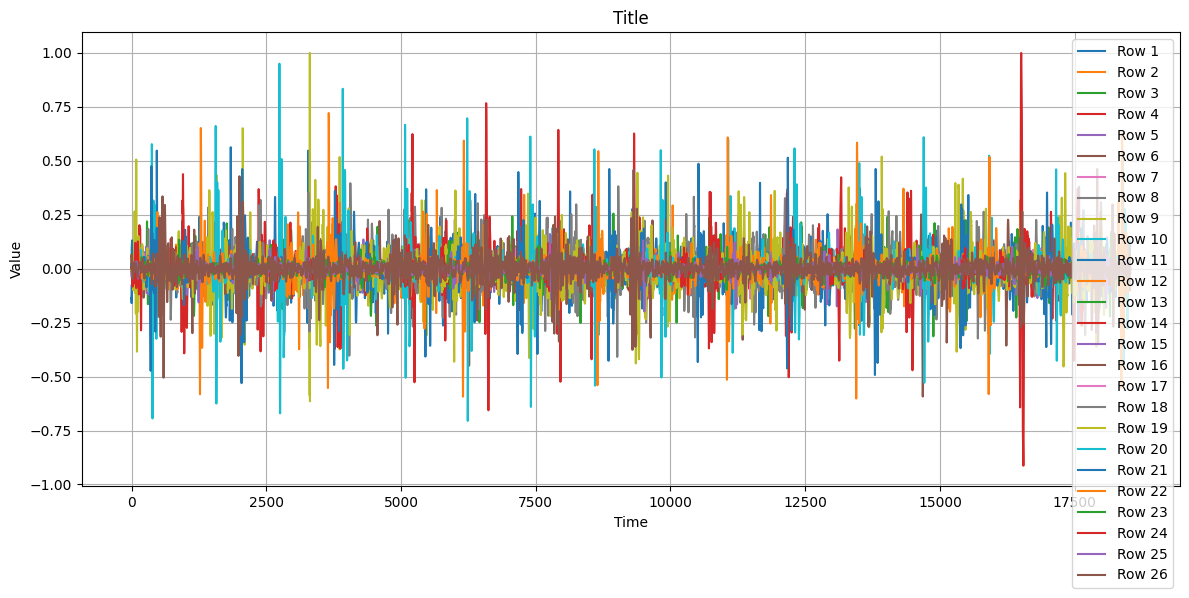

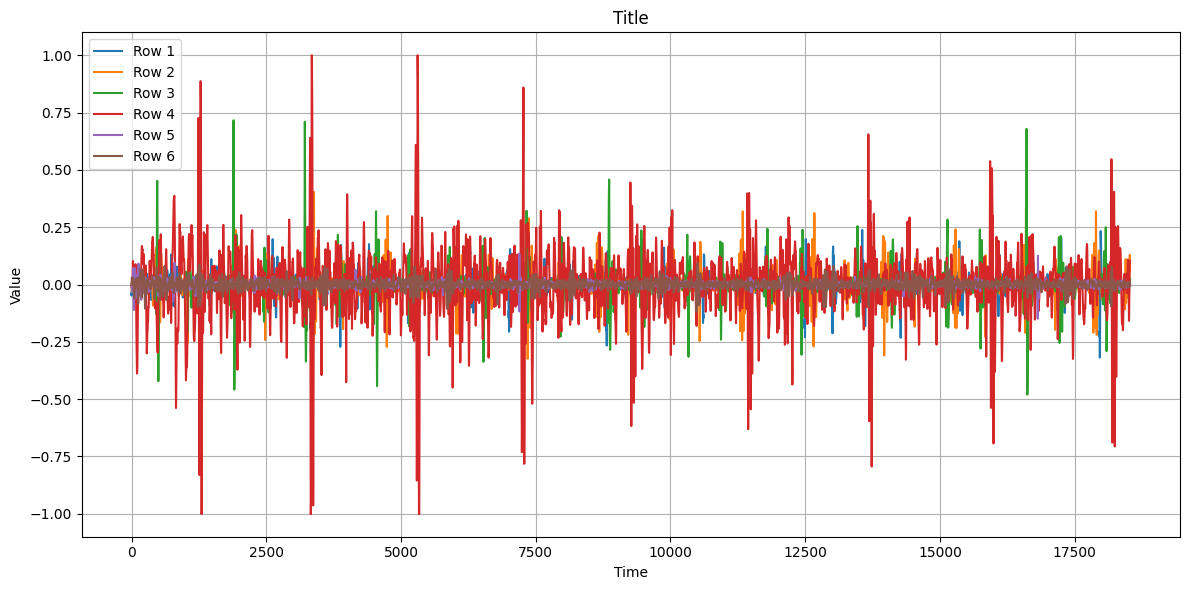

In [39]:
plot_series(X_train[y_train==0].squeeze(1))
plot_series(X_train[y_train==1].squeeze(1))

In [71]:
# plot_series()

# start_chunk = 0 
# data = X_train[y_train==1].squeeze(1)[0,:]

# # print(data.shape)

# step = 200
# for i, chunk in enumerate(range(step, data.shape[0], step)):
#     # plot_series([data[start_chunk:chunk]], save_path=f'.temp/ab_heart/neg/{step}/pic_{i}.png')
#     plot_series([data[start_chunk:chunk]], save_path=f'.temp/ab_heart/pos/{step}/pic_{i}.png')

#     start_chunk = chunk

# for i, row in enumerate(range(X_train[y_train==1].squeeze(1).shape[0])):
#     plot_series([row], save_path=f'.temp/ab_heart/pos/orig/pic_{i}.png')

# for i, row in enumerate(X_test[y_test==1].squeeze(1)):
#     plot_series([row], save_path=f'.temp/ab_heart/pos/orig2/pic_{i}.png')

/home/ilia_linux/patrec_time_series/.basic_venv/lib/python3.12/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/home/ilia_linux/patrec_time_series/.basic_venv/lib/python3.12/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


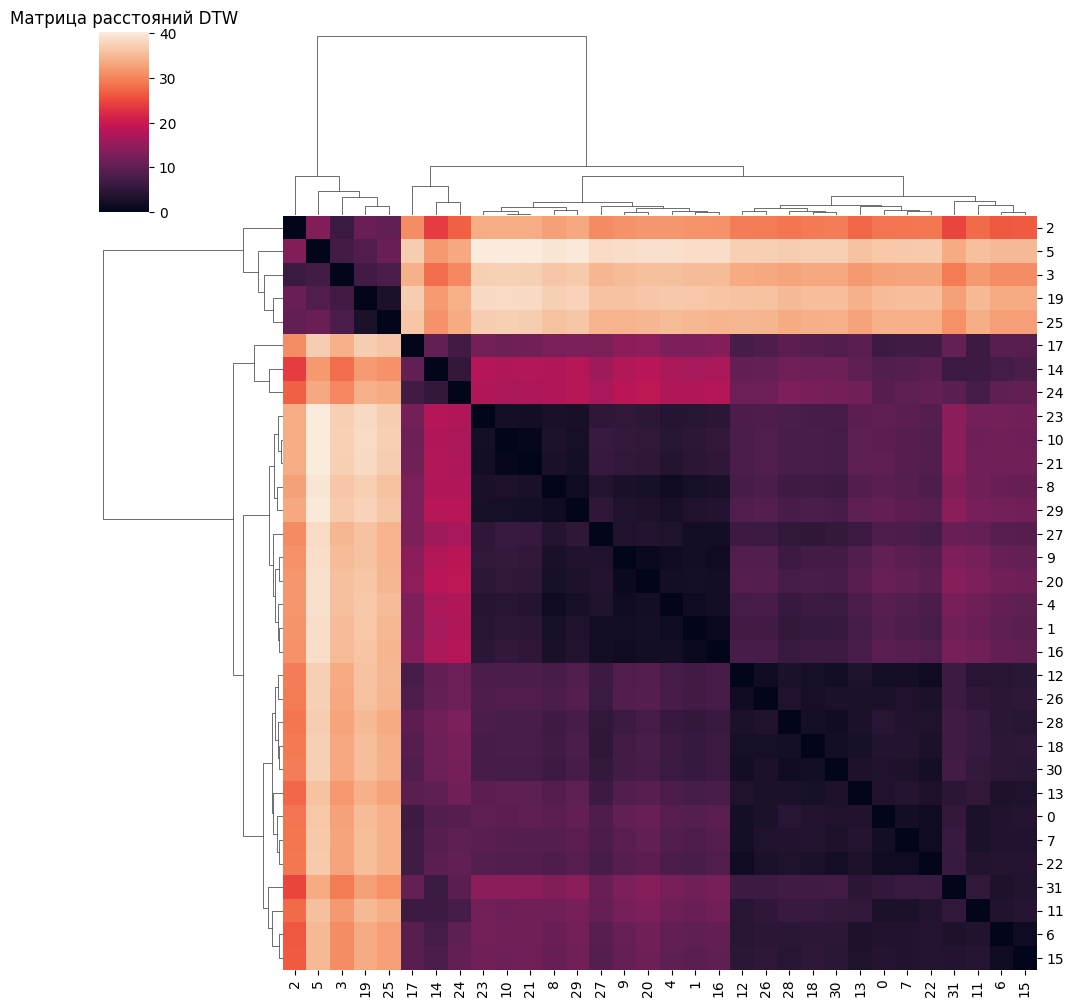

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
from tslearn.metrics import cdist_dtw
distance_matrix = cdist_dtw(X_train)  # для экономии времени берем подвыборку
sns.clustermap(distance_matrix, row_cluster=True, col_cluster=True)

plt.title("Матрица расстояний DTW")
plt.show()